In [ ]:
import pip
pip.main(["install","matplotlib"])
pip.main(["install","numpy"])
pip.main(["install","seaborn"])
pip.main(["install","pandas"])

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import os, sys
import seaborn as sns
import pandas as pd

In [182]:
approach_to_fpath_dict = {
                          "Single Shot (KKT)": {
                              0: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_23_9_27_248\\kkt_Pop_2022_6_20_23_9_27_335.txt"],
                          },
                          "Simulated Annealing": {
                                    0: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_20_0_53_534\\simulatedannealing_Pop_0_2022_6_20_20_34_14_344.txt"],
                                    1: ["..\logs\\gap_vs_time\\Pop_2_2022_6_20_20_0_53_534\\simulatedannealing_Pop_1_2022_6_20_21_24_14_653.txt"],
                                    2: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_23_9_27_248\\simulatedannealing_Pop_2_2022_6_20_23_42_48_28.txt"],
                                    3: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_23_9_27_248\\simulatedannealing_Pop_3_2022_6_21_0_32_48_126.txt"]
                            },
                         "Hill Climber": {
                                    0: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_20_0_53_534\\hillclimbing_Pop_0_2022_6_20_20_17_34_203.txt"],
                                    1: ["..\logs\gap_vs_time\\Pop_2_2022_6_20_20_0_53_534\hillclimbing_Pop_1_2022_6_20_21_7_34_529.txt"],
                                    2: ["..\\logs\gap_vs_time\\Pop_2_2022_6_20_23_9_27_248\\hillclimbing_Pop_2_2022_6_20_23_26_7_908.txt"],
                                    3: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_23_9_27_248\\hillclimbing_Pop_3_2022_6_21_0_16_8_94.txt"]
                            },
                        "Random": {
                                    0: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_20_0_53_534\\randomSearch_Pop_0_2022_6_20_20_50_54_433.txt"],
                                    1: ["..\logs\gap_vs_time\\Pop_2_2022_6_20_20_0_53_534\\randomSearch_Pop_1_2022_6_20_21_40_54_887.txt"],
                                    2: ["..\\logs\gap_vs_time\\Pop_2_2022_6_20_23_9_27_248\\randomSearch_Pop_2_2022_6_20_23_59_28_53.txt"],
                                    3: ["..\\logs\\gap_vs_time\\Pop_2_2022_6_20_23_9_27_248\\randomSearch_Pop_3_2022_6_21_0_49_28_169.txt"]
                                  }
                        }
approach_to_dur_gap_mapping = dict()


In [183]:
output_fig_dir = "..\\figs\\"
if not os.path.isdir(output_fig_dir):
    os.mkdir(output_fig_dir)

In [209]:
def analyze_log_files(approach_to_fpath_dict, approach_to_dur_gap_mapping):
    max_gap = 0
    norm_factor = 38 * 5000
    df_dictionary = {"approach": [], "gap": [], "dur": [], "seed": []}
    for approach, seed_fpath_list in approach_to_fpath_dict.items():
        for seed, fpath_list in seed_fpath_list.items():
            gap_list = []
            dur_list = []
            seen_dur = set()
            prev_dur = 0
            prev_gap = 0
            bias_dur = None
            decimals = 3
            for fpath in fpath_list:
                with open(fpath, "r") as fp:
                    for fline in fp.readlines():
                        dur_ms, gap = fline.split(",")
                        gap = np.maximum(0, float(gap)) * 100/ norm_factor
                        abs_dur = int(dur_ms) / 1000
                        if bias_dur is None:
                            bias_dur = abs_dur
                        dur = np.round((abs_dur - bias_dur), decimals=decimals)
                        gap_list.append(gap)
                        dur_list.append(dur)
                        max_gap = np.maximum(max_gap, gap)
                        change_lane = False
                        while dur > prev_dur + np.power(10.0, -decimals):
                            prev_dur += np.power(10.0, -decimals)
                            if not change_lane and 10 >= prev_dur > 1:
                                prev_dur -= np.power(10.0, -decimals)
                                change_lane = True
                                decimals = 2
                                prev_dur = np.round(prev_dur, decimals=decimals)
                                continue
                            if not change_lane and 100 >= prev_dur > 10:
                                prev_dur -= np.power(10.0, -decimals)
                                change_lane = True
                                decimals = 1
                                prev_dur = np.round(prev_dur, decimals=decimals)
                                continue
                            if not change_lane and 1000 >= prev_dur > 100:
                                prev_dur -= np.power(10.0, -decimals)
                                change_lane = True
                                decimals = 0
                                prev_dur = np.round(prev_dur, decimals=decimals)
                                continue
                            if not change_lane and prev_dur > 1000:
                                prev_dur -= np.power(10.0, -decimals)
                                change_lane = True
                                decimals = -1
                                prev_dur = np.round(prev_dur, decimals=decimals)
                                continue
                            prev_dur = np.round(prev_dur, decimals=decimals)
                            df_dictionary["approach"].append(approach)
                            df_dictionary["gap"].append(prev_gap)
                            df_dictionary["dur"].append(prev_dur)
                            df_dictionary["seed"].append(seed)
                            seen_dur.add(prev_dur)
                        prev_dur = dur
                        prev_gap = gap
                        prev_dur = np.round(prev_dur, decimals=decimals)
                        if (prev_dur in seen_dur):
                            df_dictionary["gap"][-1] = gap
                            df_dictionary["dur"][-1] = prev_dur
                        else:
                            df_dictionary["approach"].append(approach)
                            df_dictionary["gap"].append(gap)
                            df_dictionary["dur"].append(prev_dur)
                            df_dictionary["seed"].append(seed)
                            seen_dur.add(prev_dur)
                        if prev_dur > 1:
                            time_step = 0.01
                        if prev_dur > 10:
                            time_step = 0.1
                        if prev_dur > 100:
                            time_step = 1
                        if prev_dur > 1000:
                            time_step = 10
                        prev_dur = np.round(prev_dur, decimals=decimals)
            gap_list = np.array(gap_list)
            dur_list = np.array(dur_list)
            sort_idx = np.argsort(dur_list)
            approach_to_dur_gap_mapping[approach] = [dur_list[sort_idx], gap_list[sort_idx]]
    data_df = pd.DataFrame(df_dictionary)
    data_df = data_df.round(decimals = 5)
    print("max_gap:", max_gap)
    return data_df
    # print(approach_to_dur_gap_mapping)

In [210]:
data_df = analyze_log_files(approach_to_fpath_dict, approach_to_dur_gap_mapping)
data_df

max_gap: 44.73712713755863


,approach,gap,dur,seed
0,Single Shot (KKT),0.00000,0.000,0
1,Single Shot (KKT),0.00000,0.001,0
2,Single Shot (KKT),0.00000,0.002,0
3,Single Shot (KKT),0.00000,0.003,0
4,Single Shot (KKT),0.00000,0.004,0
...,...,...,...,...
48158,Random,30.14861,996.000,3
48159,Random,30.14861,997.000,3
48160,Random,30.14861,998.000,3
48161,Random,30.14861,999.000,3


In [ ]:
data_df_1 = data_df.loc[(data_df["dur"] < 5.5) & (data_df["dur"] > 5) & (data_df["seed"] == 1) & (data_df["approach"] == "Random")]
data_df_1

In [ ]:
data_df_0 = data_df.loc[(data_df["dur"] < 1.05) & (data_df["dur"] > 0.99) & (data_df["seed"] == 0)]
data_df_0

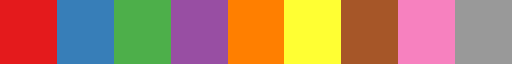

In [188]:
color_pallette = plt.get_cmap("Set1")
color_pallette

In [226]:
dash_list = sns._core.unique_dashes(data_df["approach"].unique().size+1)
dash_list

['', (4, 1.5), (1, 1), (3, 1.25, 1.5, 1.25), (5, 1, 1, 1)]

In [227]:
# colors = [color_pallette(3), color_pallette(0), color_pallette(4), color_pallette(2)]
# colors = [color_pallette(1), color_pallette(2), color_pallette(3), color_pallette(4)]
# colors = [color_pallette(1), color_pallette(3), color_pallette(2), color_pallette(0)]
colors = [color_pallette(1), color_pallette(3), color_pallette(2), color_pallette(4)]
style_col = "approach"
line_styles = {key:value for key,value in zip(data_df[style_col].unique(), dash_list[1:])}

KeyboardInterrupt: 

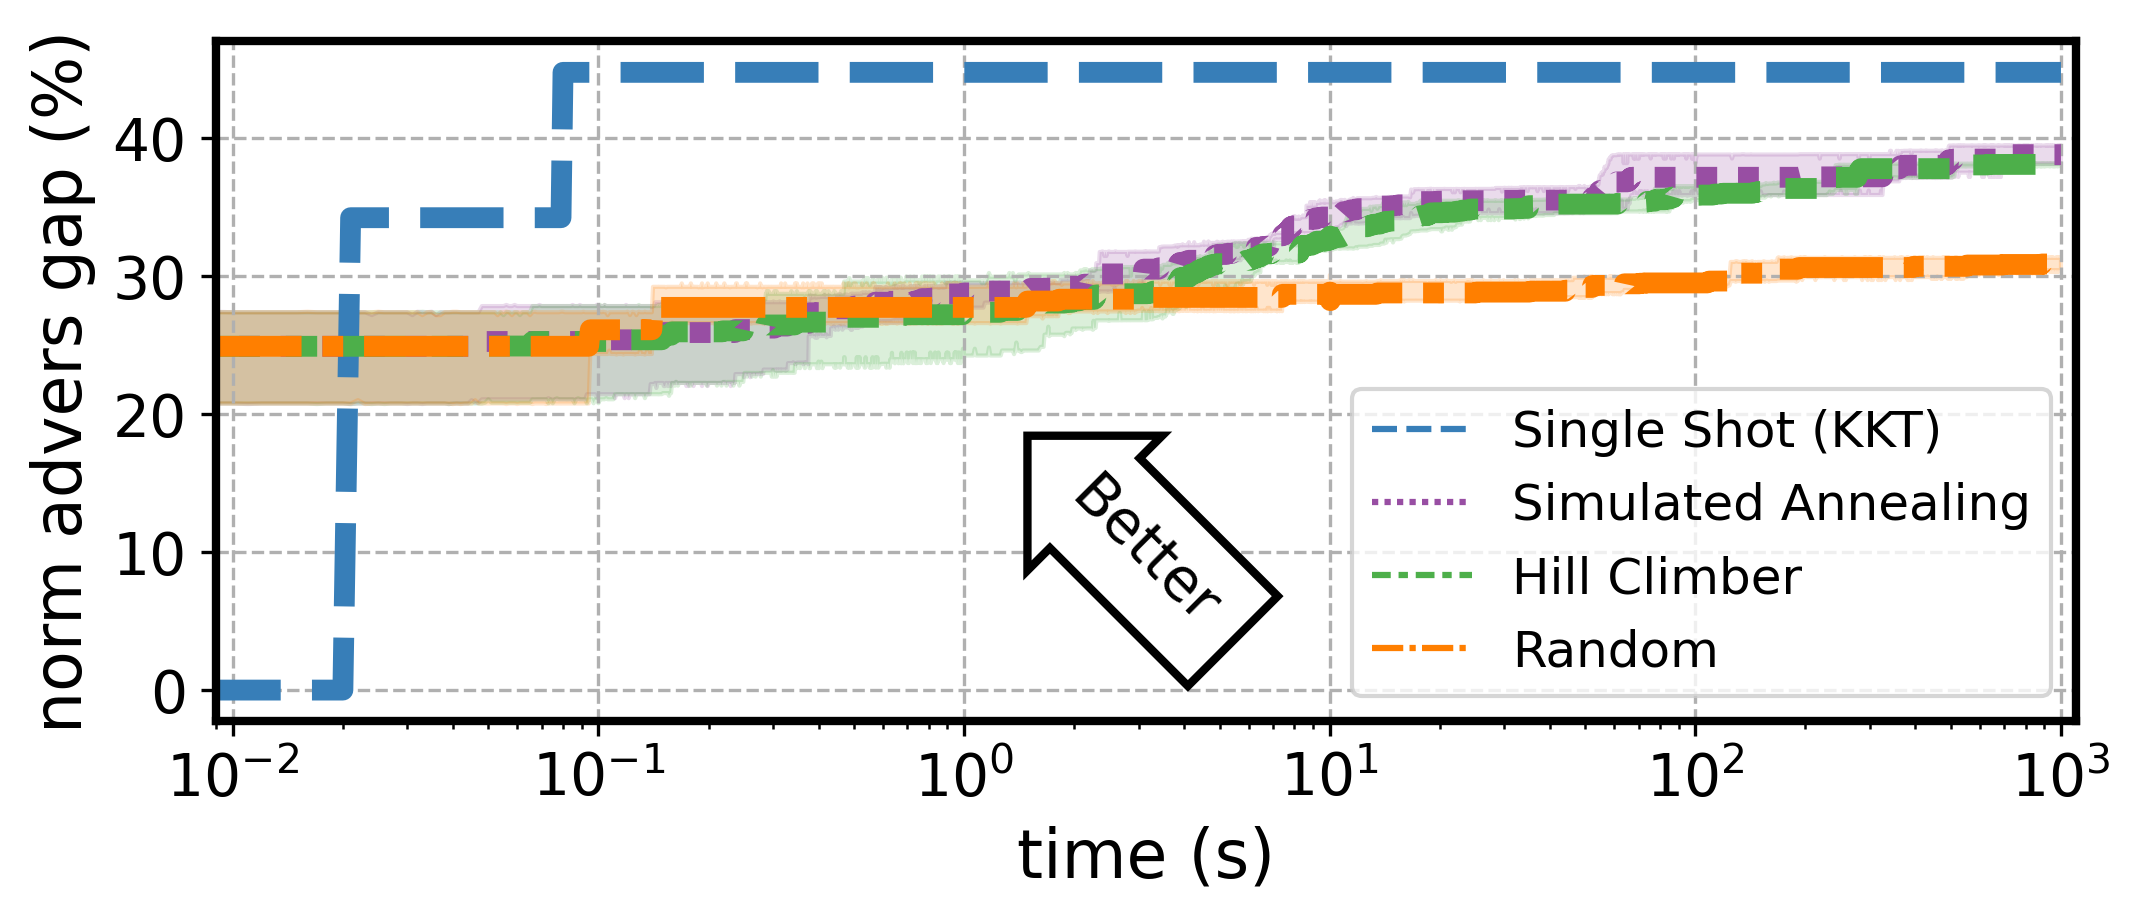

In [238]:
plt.rc('axes', linewidth=2)
plt.figure(figsize=(8, 3), dpi=300)
x_min = np.inf
# for idx, (approach, output) in enumerate(approach_to_dur_gap_mapping.items()):
#     plt.plot(output[0], output[1] * 100/ norm_factor, label=approach, color=colors[idx], linestyle=line_styles[idx], 
#             #  marker="o", 
#             #  mfc="white", 
#             #  mec=colors[idx], 
#             #  markersize=10, 
#              linewidth=3, 
#             #  markeredgewidth=3
#     )
#     x_min = np.minimum(x_min, np.min(output[0]))
sns.lineplot(x="dur", y="gap",
             hue="approach", data=data_df, palette=colors, 
             style="approach",
             dashes=line_styles,
             linewidth=5,
             ms=14,
             hue_order=["Single Shot (KKT)", "Simulated Annealing", "Hill Climber", "Random"]
             )
# #add arrow to plot
# plt.arrow(x=4, y=0.75, dx=0, dy=0.1, width=0.5, head_length=0.03, fc="white") 

#add annotation
min_y = 10
size_arrow = 14
min_x = 3.1
# plt.annotate('Better', xy = (3.1, min_y - 0.1))
bbox_props = dict(boxstyle="larrow,pad=0.3", ec="black", fc="white", lw=2)
t = plt.text(min_x, min_y, "Better", ha="center", va="center", rotation=-45,
             size=size_arrow,
             bbox=bbox_props)
bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.6)

plt.legend(fontsize=12, loc="lower right")
# plt.title("Pop2 + 2-shortest paths on B4", fontsize=16)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("norm advers gap (%)", fontsize=16)
plt.xscale('log')
# plt.yticks(np.arange(0.25, 0.47, 0.03), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([0.01, 0.1, 1, 10, 100, 1000], fontsize=14)
plt.xlim([0.009, 1100])
# plt.ylim([0, 46])
plt.grid(which="major", zorder=-1, linestyle="--")
plt.savefig(output_fig_dir + "pop2_2sp.jpg", bbox_inches="tight", format="jpg", dpi=300)
plt.savefig(output_fig_dir + "pop2_2sp.pdf", bbox_inches="tight", format="pdf", dpi=300)
print(x_min)

In [232]:
dp_approach_to_fpath_dict = {
                          "Single Shot (KKT)": {
                              0: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\kkt_DemandPinning_2022_6_21_1_6_8_261.txt"],
                          },
                          "Simulated Annealing": {
                                    0: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\simulatedannealing_DemandPinning_0_2022_6_21_3_52_49_60.txt"],
                                    1: ["..\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\simulatedannealing_DemandPinning_1_2022_6_21_8_2_49_241.txt"],
                                    2: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\simulatedannealing_DemandPinning_2_2022_6_21_12_12_49_443.txt"],
                                    3: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\simulatedannealing_DemandPinning_3_2022_6_21_16_22_49_720.txt"]
                            },
                         "Hill Climber": {
                                    0: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\hillclimbing_DemandPinning_0_2022_6_21_2_29_28_984.txt"],
                                    1: ["..\logs\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\hillclimbing_DemandPinning_1_2022_6_21_6_39_29_204.txt"],
                                    2: ["..\\logs\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\hillclimbing_DemandPinning_2_2022_6_21_10_49_29_351.txt"],
                                    3: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\hillclimbing_DemandPinning_3_2022_6_21_14_59_29_592.txt"]
                            },
                        "Random": {
                                    0: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\randomSearch_DemandPinning_0_2022_6_21_5_16_9_107.txt"],
                                    1: ["..\logs\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\randomSearch_DemandPinning_1_2022_6_21_9_26_9_322.txt"],
                                    2: ["..\\logs\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\randomSearch_DemandPinning_2_2022_6_21_13_36_9_545.txt"],
                                    3: ["..\\logs\\gap_vs_time\\DemandPinning_2022_6_21_1_6_8_208\\randomSearch_DemandPinning_3_2022_6_21_17_46_9_828.txt"]
                                  }
                        }
dp_approach_to_dur_gap_mapping = dict()

In [233]:
dp_data_df = analyze_log_files(dp_approach_to_fpath_dict, dp_approach_to_dur_gap_mapping)
dp_data_df

max_gap: 22.763157897088245


,approach,gap,dur,seed
0,Single Shot (KKT),0.00000,0.000,0
1,Single Shot (KKT),0.00000,0.001,0
2,Single Shot (KKT),0.00000,0.002,0
3,Single Shot (KKT),0.00000,0.003,0
4,Single Shot (KKT),0.00000,0.004,0
...,...,...,...,...
97132,Random,1.50617,4996.000,3
97133,Random,1.50617,4997.000,3
97134,Random,1.50617,4998.000,3
97135,Random,1.50617,4999.000,3


inf


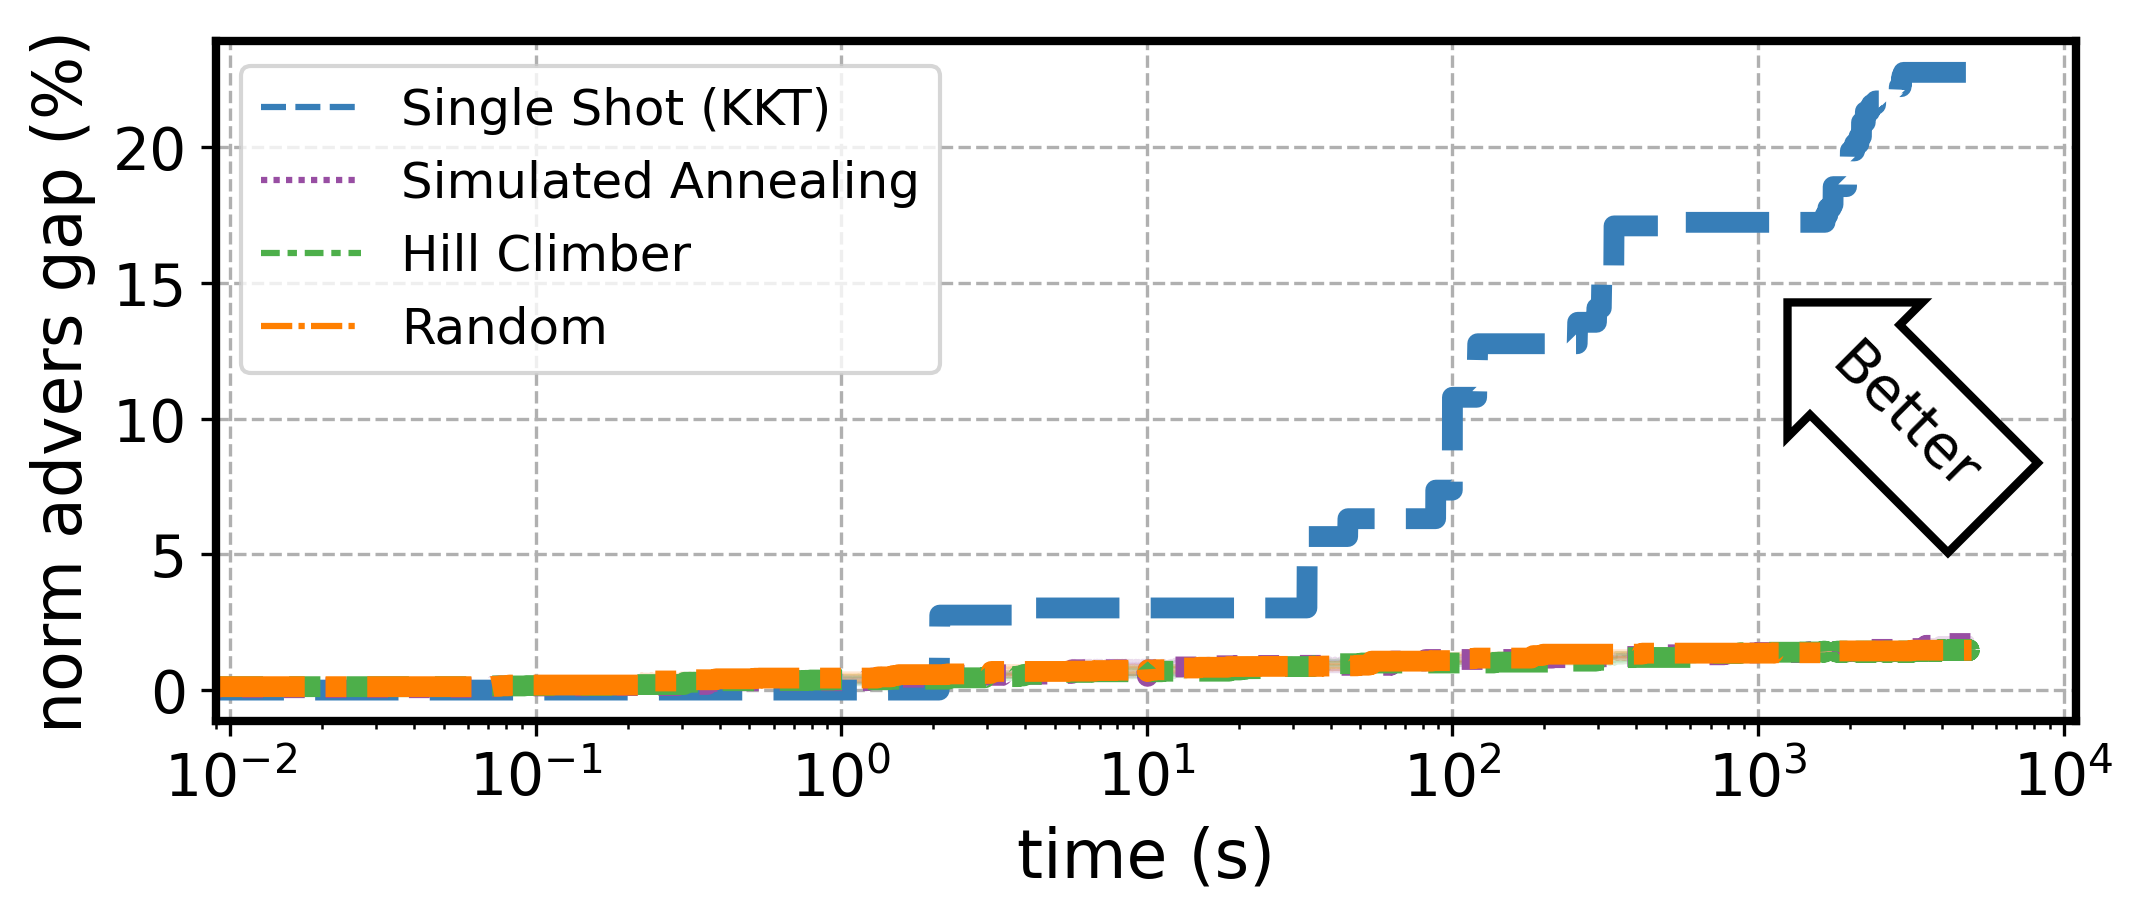

In [240]:
plt.rc('axes', linewidth=2)
plt.figure(figsize=(8, 3), dpi=300)
x_min = np.inf
# for idx, (approach, output) in enumerate(approach_to_dur_gap_mapping.items()):
#     plt.plot(output[0], output[1] * 100/ norm_factor, label=approach, color=colors[idx], linestyle=line_styles[idx], 
#             #  marker="o", 
#             #  mfc="white", 
#             #  mec=colors[idx], 
#             #  markersize=10, 
#              linewidth=3, 
#             #  markeredgewidth=3
#     )
#     x_min = np.minimum(x_min, np.min(output[0]))
sns.lineplot(x="dur", y="gap",
             hue="approach", data=dp_data_df, palette=colors, 
             style="approach",
             dashes=line_styles,
             linewidth=5,
             ms=14,
             hue_order=["Single Shot (KKT)", "Simulated Annealing", "Hill Climber", "Random"]
             )
# #add arrow to plot
# plt.arrow(x=4, y=0.75, dx=0, dy=0.1, width=0.5, head_length=0.03, fc="white") 

#add annotation
min_y = 10
size_arrow = 14
min_x = 3000
# plt.annotate('Better', xy = (3.1, min_y - 0.1))
bbox_props = dict(boxstyle="larrow,pad=0.3", ec="black", fc="white", lw=2)
t = plt.text(min_x, min_y, "Better", ha="center", va="center", rotation=-45,
             size=size_arrow,
             bbox=bbox_props)
bb = t.get_bbox_patch()
bb.set_boxstyle("larrow", pad=0.6)

plt.legend(fontsize=12, loc="upper left")
# plt.title("Pop2 + 2-shortest paths on B4", fontsize=16)
plt.xlabel("time (s)", fontsize=16)
plt.ylabel("norm advers gap (%)", fontsize=16)
plt.xscale('log')
# plt.yticks(np.arange(0.25, 0.47, 0.03), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([0.01, 0.1, 1, 10, 100, 1000, 10000], fontsize=14)
plt.xlim([0.009, 11000])
# plt.ylim([0, 46])
plt.grid(which="major", zorder=-1, linestyle="--")
plt.savefig(output_fig_dir + "dp5_2sp.jpg", bbox_inches="tight", format="jpg", dpi=300)
plt.savefig(output_fig_dir + "dp5_2sp.pdf", bbox_inches="tight", format="pdf", dpi=300)
print(x_min)